In [56]:
from skimage.io.collection import ImageCollection
from skimage.io import imread
from skimage.color import rgb2gray
from joblib import Parallel,delayed
from typing import Tuple, List
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt


In [57]:
"""
   Load images from DataBase and QuerySets
"""
def load_data() -> Tuple[np.ndarray,np.ndarray,np.ndarray]:
   # We use ImageCollection to load all images inside folders
   db = ImageCollection("../data/BBDD/*.jpg")
   print('BBDD read: {} images'.format(len(db)))
   qs1 = ImageCollection("../data/qsd1_w1/*.jpg")
   print('QuerySet1 read: {} images'.format(len(qs1)))
   qs2 = ImageCollection("../data/qsd2_w1/*.jpg")
   print('QuerySet2 read: {} images'.format(len(qs2)))
    
   return db, qs1, qs2

In [58]:
"""
   Computes image's histograms for each color channel (r,g,b) and concatenates them
   to create a feature vector
"""
def get_histogram_vector(image: np.ndarray,n_bins: int = 16) -> np.ndarray:
   # Histogram calculation per Red, Green, Blue and Gray Channel using n_bins
   r_hist = np.histogram(image[:, :, 0],bins=n_bins)[0]
   g_hist = np.histogram(image[:, :, 1],bins=n_bins)[0]
   b_hist = np.histogram(image[:, :, 2],bins=n_bins)[0]
   gray_hist = np.histogram(rgb2gray(image),bins=n_bins)[0]
   
   # Join all Histograms into a single feature vector
   feature_vector = np.hstack((r_hist,g_hist,b_hist,gray_hist))
   
   return feature_vector


"""
   Computes feature vector for each image of our dataset.
"""    
def get_feature_matrix(dataset: np.ndarray, desc: str, n_bins: int = 16) -> np.ndarray:
   # Build feature matrix applying get_histogram_vector over all images in dataset
   # We apply some multiprocessing so we can reduce processing time by half
   feature_matrix = Parallel(n_jobs=2)(delayed(get_histogram_vector)(image,n_bins)for image in tqdm(dataset,desc=desc))
   return np.array(feature_matrix)  

In [73]:
"""
   Computes cos similarity between feature vector and all BBDD feature vectors
"""    
def cos_similarity(vector: np.ndarray) -> np.ndarray:
   # We take profit of numpy broadcasting to calculate cos similarity between the provided vector and all BBDD features
   return db_feature_matrix.dot(vector)/ (np.linalg.norm(db_feature_matrix, axis=1) * np.linalg.norm(vector))


"""
   Computes euclidean similarity between feature vector and all BBDD feature vectors
"""   
def euclidean_similarity(vector: np.ndarray) -> np.ndarray:
   # We take profit of numpy broadcasting to calculate euclidean similarity between the vector and all BBDD features
   dist = (db_feature_matrix - vector)**2
   dist = np.sum(dist, axis=1)
   dist = np.sqrt(dist)
   dist = np.max(dist) - dist
   return dist


"""
   Computes similairty for an entire QuerySet
"""    
def compute_similarities(qs: np.ndarray,desc: str) -> np.ndarray:
   # Perform similarity for each vector in the QuerySet
   return np.array([cos_similarity(vector) for vector in tqdm(qs,desc=desc)])



In [74]:
"""
   Retrieves the top k similar images for a vector.
"""    
def get_top_k_vector(similarity_vector: np.ndarray, k: int) -> List[str]:
   # We get top K index of the vector (unordered)
   idx = np.argpartition(similarity_vector, -k)[-k:]
   
   # Then we order index in order to get the ordered top k values
   top_k = list(similarity_vector[idx])
   sorted_top = list(sorted(top_k,reverse=True))
   idx = [idx[top_k.index(i)] for i in sorted_top]
   
   # ImageCollection also saves in .files so we can easily retrieve them
   return [db.files[i] for i in idx]


"""
   Retrieves the top k similar images for a QuerySEt
"""    
def get_top_k(similarity_matrix: np.ndarray, k: int, desc: str) -> List[List[str]]:
   # Estimate top k values for all the Queryet
   return [get_top_k_vector(vector,k) for vector in tqdm(similarity_matrix, desc = desc)]


"""
   Retrieves the top k similar images for a vector.
"""    
def get_bot_k_vector(similarity_vector: np.ndarray, k: int) -> List[str]:
   # We get bot K index of the vector (unordered)
   idx = similarity_vector.argsort()[:k]
   
   # Then we order index in order to get the ordered bot k values
   bot_k = list(similarity_vector[idx])
   sorted_bot = list(sorted(bot_k,reverse=False))
   idx = [idx[bot_k.index(i)] for i in sorted_bot]
   
   # ImageCollection also saves in .files so we can easily retrieve them
   return [db.files[i] for i in idx]


"""
   Retrieves the bot k similar images for a QuerySet.
"""    
def get_bot_k(similarity_matrix: np.ndarray, k: int, desc: str) -> List[List[str]]:
   # Estimate bot k values for all the Queryet
   return [get_bot_k_vector(vector,k) for vector in tqdm(similarity_matrix, desc = desc)]
 
 

In [75]:
"""
   Plot Base Image and top 3 closest images
"""   
def plot_image_and_similar(image,similar) -> None:
    f, axarr = plt.subplots(2,2, figsize=(10,10))
    axarr[0,0].imshow(image)
    axarr[0,0].title.set_text("Base")
    axarr[0,1].imshow(similar[0])
    axarr[0,1].title.set_text("Query 1")
    axarr[1,0].imshow(similar[1])
    axarr[1,0].title.set_text("Query 2")
    axarr[1,1].imshow(similar[2])
    axarr[1,1].title.set_text("Query 3")

In [76]:
db, qs1, qs2 = load_data()

db_feature_matrix = get_feature_matrix(dataset = db, n_bins = 32, desc = "Creating feature matrix for BBDD...")
qs1_feature_matrix = get_feature_matrix(dataset = qs1, n_bins = 32, desc = "Creating feature matrix for QuerySet1...")
qs2_feature_matrix = get_feature_matrix(dataset = qs2, n_bins = 32, desc = "Creating feature matrix for QuerySet2...")

qs1_similarities = compute_similarities(qs = qs1_feature_matrix, desc = "Computing qs1 similarities...")
qs2_similarities = compute_similarities(qs = qs2_feature_matrix, desc = "Computing qs2 similarities...")

top_k_qs1 = get_top_k(qs1_similarities, 3, desc = "Retrieving qs1 top K similar images...")
top_k_qs2 = get_top_k(qs2_similarities, 3, desc = "Retrieving qs2 top K similar images...")

bot_k_qs1 = get_bot_k(qs1_similarities, 3, desc = "Retrieving qs1 bot K similar images...")
bot_k_qs2 = get_bot_k(qs2_similarities, 3, desc = "Retrieving qs2 bot K similar images...")

Creating feature matrix for BBDD...:   1%|▏         | 4/287 [00:00<00:10, 27.30it/s]

BBDD read: 287 images
QuerySet1 read: 30 images
QuerySet2 read: 30 images


Retrieving qs2 bot K similar images...: 100%|██████████| 30/30 [00:00<00:00, 28397.45it/s]


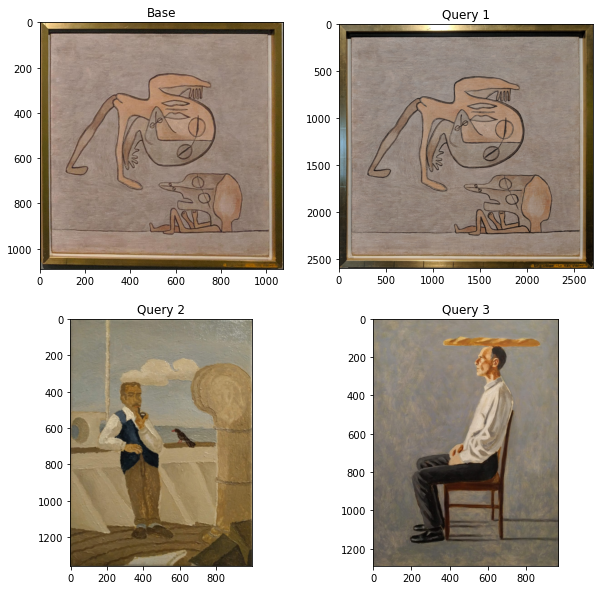

In [77]:
# Example plot 1
plot_image_and_similar(qs1[0],[imread(image) for image in top_k_qs1[0]])

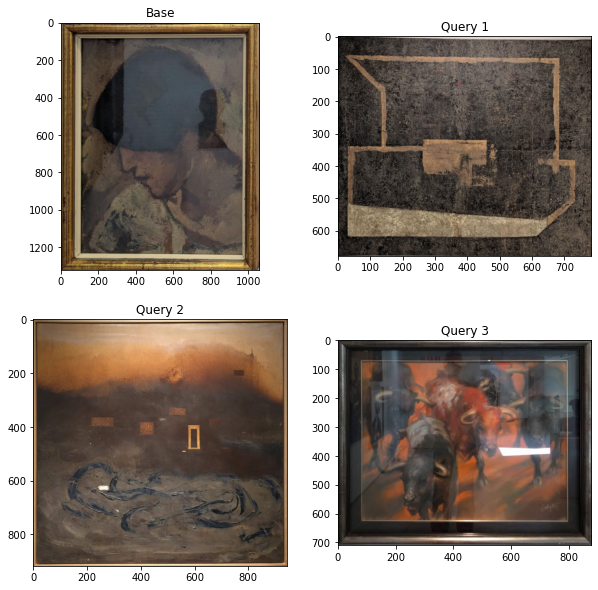

In [78]:
# Example plot 2
plot_image_and_similar(qs1[1],[imread(image) for image in top_k_qs1[1]])

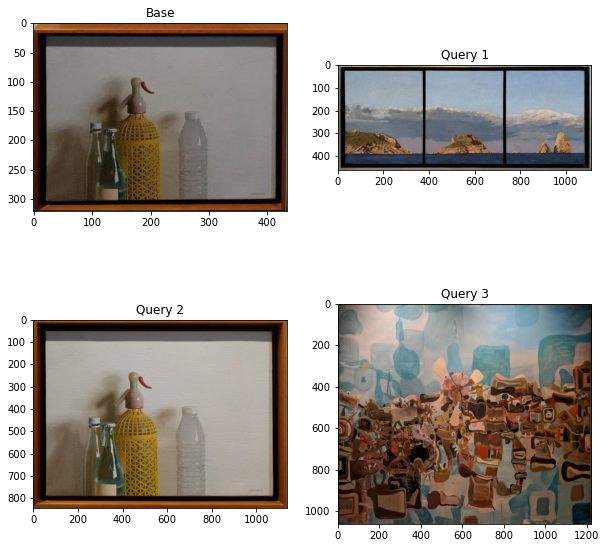

In [79]:
# Example plot 3
plot_image_and_similar(qs1[2],[imread(image) for image in top_k_qs1[2]])